# Natural Language Processing : analyse des sentiments sur les données de SMS


- En repartant de la table des SMS, calculez les niveaux de subjectivité et de positivité des textos analysés et stockez ces informations dans deux nouvelles variables de la table.  
- Représentez graphiquement la répartition des textos en fonction de leur subjectivité et de leur polarité. Faites apparaître dans une couleur différente les spams. Pourrait-on utiliser ces 2 variables pour repérer les spams selon vous?   
- Faites apparaître les textos les plus positifs/les textos les plus négatifs/les textos les plus subjectifs/les plus objectifs pour vérifier que la mesure fonctionne correctement.   

_Bonus_ : On s'intéresse maintenant aux spam :  
- En reprenant notre modèle de prédiction de spams, déterminez si la probabilité qu'on repère un spam comme tel dépend ou non du degré de subjectivité et de positivité de son contenu.  
(Démarche à suivre : reprendre le vecteur de probabilités d'être un spam pour les spams de y_test et représenter ces points en fonction de la positivité et de la subjectivité en colorant selon ce vecteur).  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA

from wordcloud import WordCloud

from textblob import TextBlob

## Chargement des données et nettoyage

On récupère les premières cellules du notebook `3. NLP_classification textos.ipynb` pour obtenir le dataset nettoyé ainsi que la matrice des termes.

In [2]:
# chargements données
df = pd.read_csv('smsspamcollection/SMSSpamCollection.txt', sep='\t',
                  header=None, names=['y', 'sms'])

# une fonction pour le preprocessing
def nettoyage(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", " ", text)
    text_wo_digits = re.sub('\d', '', text)
    return text, text_wo_digits

df['sms_digits'] = df.sms.apply(lambda x: nettoyage(x)[0])
df['sms_wo_digits'] = df.sms.apply(lambda x: nettoyage(x)[1])

df

,y,sms,sms_digits,sms_wo_digits
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only ...,go until jurong point crazy available only ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives aro...,nah i don t think he goes to usf he lives aro...
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,this is the nd time we have tried contact u ...
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home,will ü b going to esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other s...,pity was in mood for that so any other s...
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i d...,the guy did some bitching but i acted like i d...


In [3]:
# 1ère matrice des termes-documents à partir de laquelle on détermine les mots supplémentaires à enlever
cv = CountVectorizer(stop_words='english')
dtm = cv.fit_transform(df.sms_digits)
dtm_df = pd.DataFrame(dtm.toarray(),
                      columns=cv.get_feature_names_out(),
                      index=df.y)

# Beaucoup de colonnes, on va en enlever
sum_mots = dtm_df.groupby('y').sum()
sum_mots = sum_mots.transpose()

# On va supprimer quand le nombre d'occurences représente moins de 1% des observations
part_occur = pd.DataFrame()
for i in ['ham','spam']:
    part_occur[i] = sum_mots[i]/len(dtm_df[dtm_df.index==i])

# on récupère la part max entre les ham et les spam
part_occur_max = part_occur.max(axis=1)

# On ajoute les stop-words tous les mots dont la part max (entre ham et spam) est inférieur à 1%
sw_supp = part_occur_max[part_occur_max<=0.01].index
my_stop_words = ENGLISH_STOP_WORDS.union(sw_supp)

# on refait la matrice termes-documents avec les nouveaux stop-words
cv = CountVectorizer(stop_words=my_stop_words)
dtm = cv.fit_transform(df.sms_digits)
dtm_df = pd.DataFrame(dtm.toarray(),
                      columns=cv.get_feature_names_out(),
                      index=df.y)
dtm_df

,00,000,02,03,04,06,0800,08000839402,08000930705,0870,...,word,work,worth,www,xmas,xxx,ya,yeah,yes,yr
y,,,,,,,,,,,,,,,,,,,,,
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
spam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Début de l'exercice

- En repartant de la table des SMS, calculez les niveaux de subjectivité et de positivité des textos analysés et stockez ces informations dans deux nouvelles variables de la table.  
- Représentez graphiquement la répartition des textos en fonction de leur subjectivité et de leur polarité. Faites apparaître dans une couleur différente les spams. Pourrait-on utiliser ces 2 variables pour repérer les spams selon vous?   
- Faites apparaître les textos les plus positifs/les textos les plus négatifs/les textos les plus subjectifs/les plus objectifs pour vérifier que la mesure fonctionne correctement.   

_Bonus_ : On s'intéresse maintenant aux spam :  
- En reprenant notre modèle de prédiction de spams, déterminez si la probabilité qu'on repère un spam comme tel dépend ou non du degré de subjectivité et de positivité de son contenu.  
(Démarche à suivre : reprendre le vecteur de probabilités d'être un spam pour les spams de y_test et représenter ces points en fonction de la positivité et de la subjectivité en colorant selon ce vecteur).  

In [4]:
pos = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df['positivite'] = df.sms.apply(pos)
df['subjectivite'] = df.sms.apply(sub)
df

,y,sms,sms_digits,sms_wo_digits,positivite,subjectivite
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only ...,go until jurong point crazy available only ...,0.150000,0.762500
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,0.500000,0.500000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry in a wkly comp to win fa cup final...,0.300000,0.550000
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say so early hor u c already then say,0.100000,0.300000
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives aro...,nah i don t think he goes to usf he lives aro...,0.000000,0.000000
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...,this is the nd time we have tried contact u ...,0.180556,0.611111
5568,ham,Will ü b going to esplanade fr home?,will ü b going to esplanade fr home,will ü b going to esplanade fr home,0.000000,0.000000
5569,ham,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other s...,pity was in mood for that so any other s...,-0.112500,0.287500
5570,ham,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i d...,the guy did some bitching but i acted like i d...,0.216667,0.433333


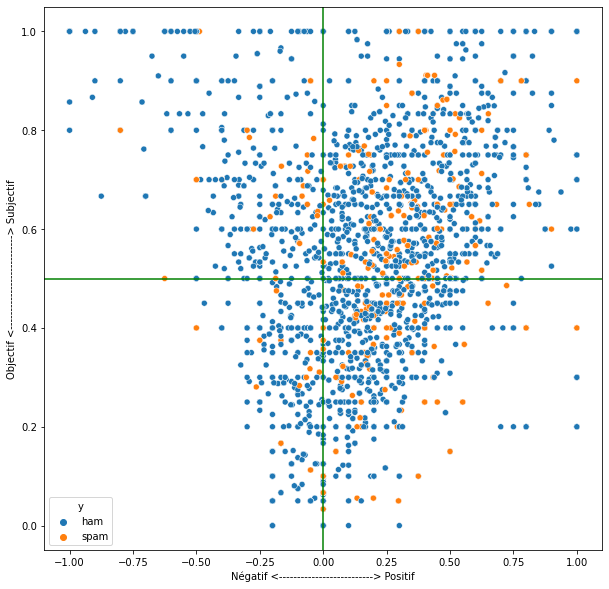

In [5]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x='positivite', y='subjectivite', hue='y')
plt.axhline(y=0.5, color='g')
plt.axvline(x=0, color='g')
plt.xlabel("Négatif <--------------------------> Positif")
plt.ylabel("Objectif <--------------------------> Subjectif");

Les spams ne semblent pas être caractérisés par leur degré de positivité/subjectivité par rapport au non spams. On va examiner quelques textos pour voir si l'évaluation fournie est pertinente.

In [6]:
# les sms non spams plutôt positifs
df.loc[(df.positivite >= 0.95) & (df.y == 'ham'), 'sms'].values

array(['Great! I hope you like your man well endowed. I am  &lt;#&gt;  inches...',
       'Sounds great! Are you home now?',
       "Awesome, I'll see you in a bit", 'Bring home some Wendy =D',
       'Love it! Daddy will make you scream with pleasure! I am going to slap your ass with my dick!',
       'I am great! How are you?',
       'Macha dont feel upset.i can assume your mindset.believe me one evening with me and i have some wonderful plans for both of us.LET LIFE BEGIN AGAIN.call me anytime',
       'Lol! U drunkard! Just doing my hair at d moment. Yeah still up 4 tonight. Wats the plan? ',
       'Talk With Yourself Atleast Once In A Day...!!! Otherwise You Will Miss Your Best FRIEND In This WORLD...!!! -Shakespeare- SHESIL  &lt;#&gt;',
       "Awesome, lemme know whenever you're around",
       'Wat makes some people dearer is not just de happiness dat u feel when u meet them but de pain u feel when u miss dem!!!',
       'Awesome, think we can get an 8th at usf some time toni

On dirait que "lol" est considéré comme positif. On peut vérifier.

In [7]:
TextBlob("lol").sentiment

Sentiment(polarity=0.8, subjectivity=0.7)

In [8]:
# les sms non spams plutôt négatifs
df.loc[(df.positivite <= -0.8) & (df.y == 'ham'), 'sms'].values

array(["We're all getting worried over here, derek and taylor have already assumed the worst",
       'Hey no I ad a crap nite was borin without ya 2 boggy with me u boring biatch! Thanx but u wait til nxt time il ave ya ',
       "Hasn't that been the pattern recently crap weekends?",
       "Annoying isn't it.",
       'Horrible gal. Me in sch doing some stuff. How come u got mc?',
       'Im in inperialmusic listening2the weirdest track ever by\x94leafcutter john\x94-sounds like insects being molested&someone plumbing,remixed by evil men on acid!',
       "Yeah jay's sort of a fucking retard",
       'Horrible bf... I now v hungry...',
       'Yes but i dont care! I need you bad, princess!',
       'The monthly amount is not that terrible and you will not pay anything till 6months after finishing school.',
       "I'm sick !! I'm needy !! I want you !! *pouts* *stomps feet* Where are you ?! *pouts* *stomps feet* I want my slave !! I want him now !!",
       'I might go 2 sch. Yar at

In [9]:
# on peut regarder les smileys
for smiley in ":) :( :-p :/ ;) ^^ :k \o/ :D :o".split():
    print(f"{smiley} : {TextBlob(smiley).sentiment}")

:) : Sentiment(polarity=0.5, subjectivity=1.0)
:( : Sentiment(polarity=-0.75, subjectivity=1.0)
:-p : Sentiment(polarity=0.75, subjectivity=1.0)
:/ : Sentiment(polarity=-0.25, subjectivity=1.0)
;) : Sentiment(polarity=0.25, subjectivity=1.0)
^^ : Sentiment(polarity=0.0, subjectivity=0.0)
:k : Sentiment(polarity=0.0, subjectivity=0.0)
\o/ : Sentiment(polarity=0.0, subjectivity=0.0)
:D : Sentiment(polarity=1.0, subjectivity=1.0)
:o : Sentiment(polarity=0.05, subjectivity=1.0)


In [10]:
# les sms spams plutôt positifs
df.loc[(df.positivite >= 0.8) & (df.y == 'spam'), 'sms'].values

array(['SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info',
       "For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. T's&C's www.txt-2-shop.com custcare 08715705022, 1x150p/wk",
       'U are subscribed to the best Mobile Content Service in the UK for £3 per 10 days until you send STOP to 82324. Helpline 08706091795',
       'UR awarded a City Break and could WIN a £200 Summer Shopping spree every WK. Txt STORE to 88039 . SkilGme. TsCs087147403231Winawk!Age16 £1.50perWKsub',
       'all the lastest from Stereophonics, Marley, Dizzee Racal, Libertines and The Strokes! Win Nookii games with Flirt!! Click TheMob WAP Bookmark or text WAP to 82468',
       'EASTENDERS TV Quiz. What FLOWER does DOT compare herself to? D= VIOLET E= TULIP F= LILY txt D E or F to 84025 NOW 4 chance 2 WIN £100 Cash WKENT/150P16+',
       'For sale - arsenal dartboard. Good condition but no doubles or trebles

In [11]:
# les sms spams plutôt négatifs
df.loc[(df.positivite <= -0.8) & (df.y == 'spam'), 'sms'].values

array(['Filthy stories and GIRLS waiting for your',
       "Do you ever notice that when you're driving, anyone going slower than you is an idiot and everyone driving faster than you is a maniac?",
       "Rock yr chik. Get 100's of filthy films &XXX pics on yr phone now. rply FILTH to 69669. Saristar Ltd, E14 9YT 08701752560. 450p per 5 days. Stop2 cancel"],
      dtype=object)

In [12]:
# les sms spams plutôt subjectifs (?)
df.loc[(df.subjectivite == 1) & (df.y == 'spam'), 'sms'].values

array(['WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
       'URGENT! Your Mobile No. was awarded £2000 Bonus Caller Prize on 5/9/03 This is our final try to contact U! Call from Landline 09064019788 BOX42WR29C, 150PPM',
       'Text & meet someone sexy today. U can find a date or even flirt its up to U. Join 4 just 10p. REPLY with NAME & AGE eg Sam 25. 18 -msg recd@thirtyeight pence',
       'URGENT! Your Mobile number has been awarded with a £2000 prize GUARANTEED. Call 09058094455 from land line. Claim 3030. Valid 12hrs only',
       'okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm',
       "+123 Congratulations - in this week's competition draw u have won the £1450 prize to claim just call 09050002311 b4280703. T&Cs/stop SMS 08718727868. Over 18 only 150ppm"

Il semblerait que les spams soient d'autant plus difficiles à repérer qu'ils ne sont pas excessivement positifs/subjectifs. Vérifions cette intuition.

Pour cela, on va faire tourner le modèle tel qu'on l'a utilisé pour la classification des spams mais en ajoutant le subjectivité et la polarité.

Sur le train : 0.9973076060130133, sur le test : 0.9802690582959641


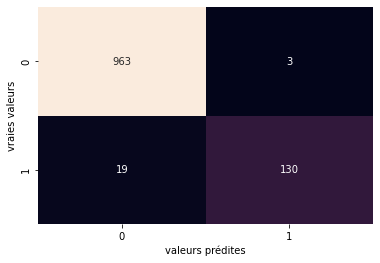

In [19]:
# on ajoute subjectivite et positivite à la matrice termes-documents
dtm_df[['positivite', 'subjectivite']] = df[['positivite', 'subjectivite']].values

# on split en entrainement-test
y = 1 * (dtm_df.index == 'spam')
X_train, X_test, y_train, y_test = train_test_split(dtm_df, y, test_size=0.2, stratify=y)

# on entraine la foret aléatoire et on regarde la précision
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train.drop(['positivite', 'subjectivite'],axis=1), y_train)
print(f"Sur le train : {rf.score(X_train.drop(['positivite', 'subjectivite'],axis=1), y_train)}, sur le test : {rf.score(X_test.drop(['positivite', 'subjectivite'],axis=1), y_test)}")

# on affiche la matrice de confusion
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test.drop(['positivite', 'subjectivite'],axis=1))), annot=True, cbar=False, fmt='d')
plt.ylabel('vraies valeurs')
plt.xlabel('valeurs prédites');

Sur le train : 0.9335876149876599, sur le test : 0.8941704035874439


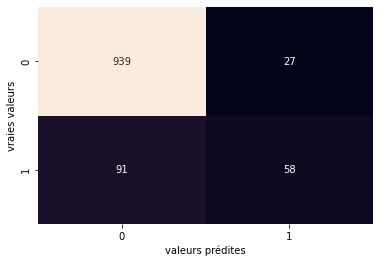

In [20]:
# on refait un modèle avec juste la subjectivité et la polarité pour prédire spam/non spam
# on entraine la foret aléatoire et on regarde la précision
rf_nul = RandomForestClassifier(n_estimators=200)
rf_nul.fit(X_train[['positivite', 'subjectivite']], y_train)
print(f"Sur le train : {rf_nul.score(X_train[['positivite', 'subjectivite']], y_train)}, sur le test : {rf_nul.score(X_test[['positivite', 'subjectivite']], y_test)}")

# on affiche la matrice de confusion
sns.heatmap(confusion_matrix(y_test, rf_nul.predict(X_test[['positivite', 'subjectivite']])), annot=True, cbar=False, fmt='d')
plt.ylabel('vraies valeurs')
plt.xlabel('valeurs prédites');

Ce modèle a beau avoir une accuracy autour de 90%, il n'est pas bon du tout car sa bonne accuracy est due au fait qu'il y a beaucoup plus de non spam environ 90%...

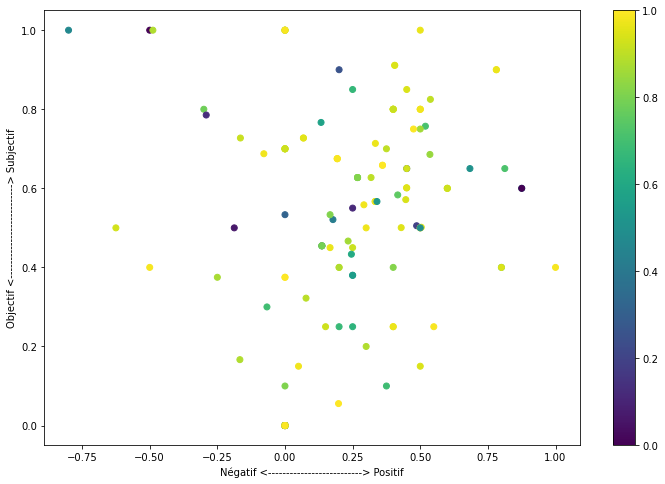

In [25]:
# on récupère les probabilités prédites
proba_spam = rf.predict_proba(X_test.drop(['positivite', 'subjectivite'], axis=1))[:,1]

# on les représente graphiquement en fonction de la positivite et de la subjectivite (pour les spams)
plt.figure(figsize=(12,8))
plt.scatter(X_test.loc[y_test==1, 'positivite'],
            X_test.loc[y_test==1, 'subjectivite'],
            c = proba_spam[y_test==1])
plt.xlabel("Négatif <--------------------------> Positif")
plt.ylabel("Objectif <--------------------------> Subjectif")
plt.colorbar();

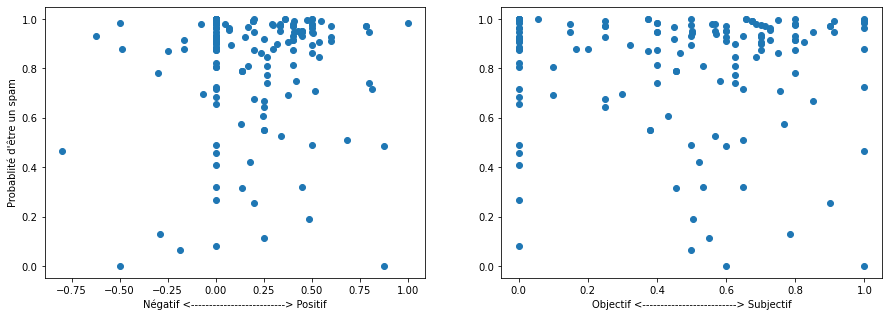

In [34]:
# on peut regarder la probabilité d'être un spam en fonction des 2 valeurs séparément
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.scatter(X_test.loc[y_test==1, 'positivite'], proba_spam[y_test==1])
ax1.set_xlabel("Négatif <--------------------------> Positif")
ax1.set_ylabel("Probablité d'être un spam")

ax2.scatter(X_test.loc[y_test==1, 'subjectivite'], proba_spam[y_test==1])
ax2.set_xlabel("Objectif <--------------------------> Subjectif");

C'est pas très concluant, mais on s'y attendait. On peut faire la même chose pour les non-spams.

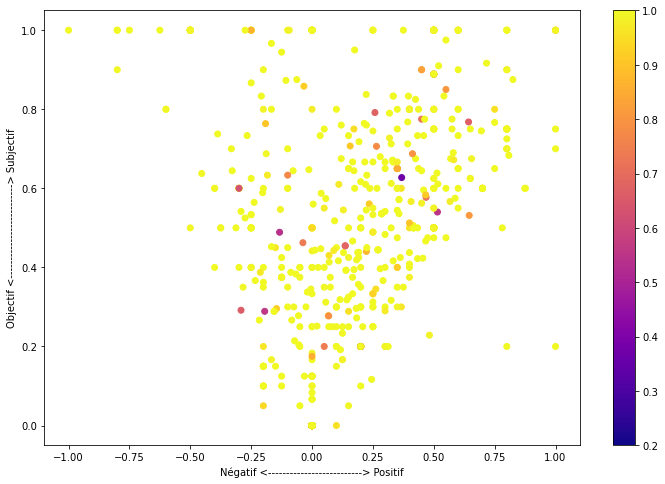

In [27]:
# on récupère les probabilités prédites
proba_no_spam = rf.predict_proba(X_test.drop(['positivite', 'subjectivite'], axis=1))[:,0]

# on les représente graphiquement en fonction de la positivite et de la subjectivite (pour les spams)
plt.figure(figsize=(12,8))
plt.scatter(X_test.loc[y_test==0, 'positivite'],
            X_test.loc[y_test==0, 'subjectivite'],
            c = proba_no_spam[y_test==0],
            cmap = 'plasma')
plt.xlabel("Négatif <--------------------------> Positif")
plt.ylabel("Objectif <--------------------------> Subjectif")
plt.colorbar();

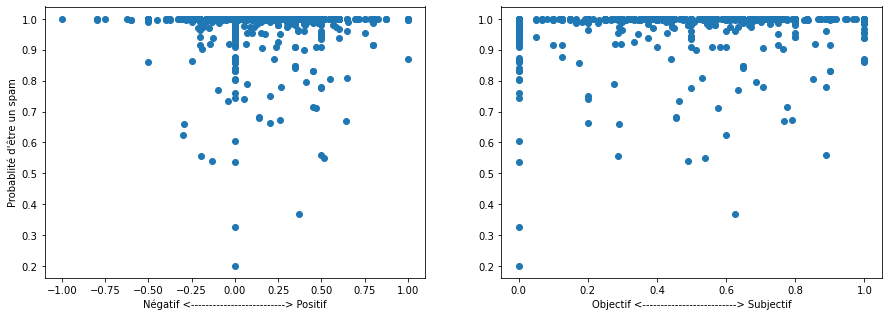

In [35]:
# on peut regarder la probabilité d'être un spam en fonction des 2 valeurs séparément
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.scatter(X_test.loc[y_test==0, 'positivite'], proba_no_spam[y_test==0])
ax1.set_xlabel("Négatif <--------------------------> Positif")
ax1.set_ylabel("Probablité d'être un spam")

ax2.scatter(X_test.loc[y_test==0, 'subjectivite'], proba_no_spam[y_test==0])
ax2.set_xlabel("Objectif <--------------------------> Subjectif");